In [7]:
# Copyright (c) 2023-2024 Pietro Luca Mazzacuva <pietroluca.mazzacuva@unicampus.it>
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

import os, sys
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from  tensorflow import keras
from tqdm import tqdm
from REDInet import Utils


def give_inputs(cell_line):
    
    if cell_line == "HEK293T":  
        samples = [["outTable_599710609", "outTable_905657585", "outTable_208420383"],
                   ["outTable_572868058", "outTable_364841872", "outTable_814257267"],
                   ["outTable_110067244", "outTable_597789462", "outTable_530905096"]]

    elif cell_line == "HEK":
        samples = [["outTable_724242056", "outTable_816573740"],
                   ["outTable_580067564", "outTable_718392497"],
                   ["outTable_181728208", "outTable_854894021"]]

    else:
        samples = [["outTable_192318299", "outTable_436061877"],
                   ["outTable_535670354", "outTable_396704193"],
                   ["outTable_773331943", "outTable_302610513"]]
   
    filespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/{}".format(cell_line)
    return samples, filespath

def make_predictions(tables, tables_filespath, model_filepath):
    
    model = tf.keras.models.load_model(model_filepath)
    with tqdm(total=int(len(tables)*len(tables[0]))) as pbar:
        for i in range(3):
            for j in range(len(tables[i])):

                intervals = pd.read_table(f"{tables_filespath}/{tables[i][j]}_intervals.tsv", sep="\t")
                X = pd.read_table(f"{tables_filespath}/{tables[i][j]}_feature_vectors.tsv", header=None, sep="\t")
                X_3d = Utils().from_2_to_3_dimensions(X, 8)
                X_3d_log2 = Utils().log_preprocessing(X_3d)
              
                output_table_prefix_filepath = "{}/{}_predictions.tsv".format(tables_filespath, tables[i][j])
                y_hat_proba = model.predict(X_3d_log2, batch_size=512, verbose=0)

                intervals["SNP_Probability"] = 1.0 - y_hat_proba
                intervals["Editing_Probability"] = y_hat_proba

                intervals.to_csv(output_table_prefix_filepath, sep="\t", index=None)
                pbar.update(1)

                
def bona_fide_metrics_calculator(tables, tables_filespath, cells):
    if cells == "HEK293T":
        prefix = "HEK(hg38)"
        suffix_1 = "WT-KO"
        suffix_2 = "OVE-KO"
    elif cells == "a549":
        prefix = cells
        suffix_1 = "WT-SI"
    else:
        prefix = "HEK(hg19)"
        suffix_1 = "WT-KO"
              
    y_true = []
    y_pred = []
    for i in range(len(tables)):
              
        sites = pd.read_table(os.path.join(tables_filespath, f"{tables[i][0]}_{tables[i][1]}_bona_fide_sites.tsv"),
                              sep="\t", usecols=["Region", "Position", "Class"])
              
        cols =  ["Region", "Position", "Strand", "Editing_Probability"]
        wt = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][0]}_predictions.tsv"), sep="\t", usecols=cols)
        adars_inactive = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][1]}_predictions.tsv"), sep="\t", usecols=cols)
        
        wt.loc[:, "index_wt"] = wt.index.tolist()
        adars_inactive.loc[:, "index_adars_inactive"] = adars_inactive.index.tolist()
        merged = wt.merge(adars_inactive, how ="inner", on=["Region", "Position", "Strand"])
        merged = merged.merge(sites, how="inner", on=["Region", "Position"])
        common_pos = merged[merged.loc[:, "Class"]==1]
        index_common_pos = common_pos.loc[:, "index_wt"].tolist()
        merged = merged[merged.loc[:, "Class"]==0]
        index_adars_inactive = merged.loc[:, "index_adars_inactive"].tolist()
        index_wt = merged.loc[:, "index_wt"].tolist()
        snps_adars_inactive = adars_inactive.iloc[index_adars_inactive, :]
        snps_wt = wt.iloc[index_wt, :]
        snps = pd.concat([snps_wt, snps_adars_inactive], axis=0)
        snps.drop(["index_wt", "index_adars_inactive"], axis=1, inplace=True)
        snps.reset_index(drop=True, inplace=True)
        index_drop = index_common_pos + index_wt
        index_drop.sort()
        pos = wt.drop(index_drop)
        pos.reset_index(drop=True, inplace=True)
        pos = pos.merge(sites, how="inner", on=["Region", "Position"])
        pos.reset_index(drop=True, inplace=True)
        
        y_true += [1 for i in range(len(pos))] + [0 for i in range(len(snps))]
        y_pred += pos.loc[:, "Editing_Probability"].tolist() + snps.loc[:, "Editing_Probability"].tolist()
        

    Utils().make_confusion_matrix(y_true,  y_pred,
                                  title = f"{prefix} {suffix_1} Inference Confusion Matrix",
                                  figsize=(6,5),
                                  path=os.path.join(tables_filespath, f"{cells}_{suffix_1}_Inference_Conf_Matrix_on.tiff"))
              
    if cells == "HEK293T":
              
        y_true = []
        y_pred = []
        for i in range(len(tables)):

            sites = pd.read_table(os.path.join(tables_filespath, f"{tables[i][2]}_{tables[i][1]}_bona_fide_sites.tsv"),
                                  sep="\t", usecols=["Region", "Position", "Class"])

            cols =  ["Region", "Position", "Strand", "Editing_Probability"]
            adars_overexpressed = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][2]}_predictions.tsv"), sep="\t", usecols=cols)
            ko = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][1]}_predictions.tsv"), sep="\t", usecols=cols)
            adars_overexpressed.loc[:, "index_adars_overexpressed"] = adars_overexpressed.index.tolist()
            ko.loc[:, "index_ko"] = ko.index.tolist()
            merged = adars_overexpressed.merge(ko, how ="inner", on=["Region", "Position", "Strand"])
            merged = merged.merge(sites, how="inner", on=["Region", "Position"])
            common_pos = merged[merged.loc[:, "Class"]==1]
            index_common_pos = common_pos.loc[:, "index_adars_overexpressed"].tolist()
            merged = merged[merged.loc[:, "Class"]==0]
            index_ko = merged.loc[:, "index_ko"].tolist()
            index_adars_overexpressed = merged.loc[:, "index_adars_overexpressed"].tolist()
            snps_ko = ko.iloc[index_ko, :]
            snps_adars_overexpressed = adars_overexpressed.iloc[index_adars_overexpressed, :]
            snps = pd.concat([snps_adars_overexpressed, snps_ko], axis=0)
            snps.drop(["index_adars_overexpressed", "index_ko"], axis=1, inplace=True)
            snps.reset_index(drop=True, inplace=True)
            index_drop = index_common_pos + index_adars_overexpressed
            index_drop.sort()
            pos = adars_overexpressed.drop(index_drop)
            pos.reset_index(drop=True, inplace=True)
            pos = pos.merge(sites, how="inner", on=["Region", "Position"])
            pos.reset_index(drop=True, inplace=True)

            y_true += [1 for i in range(len(pos))] + [0 for i in range(len(snps))]
            y_pred += pos.loc[:, "Editing_Probability"].tolist() + snps.loc[:, "Editing_Probability"].tolist()
                        
        Utils().make_confusion_matrix(y_true,  y_pred,
                              title = f"{prefix} {suffix_2} Inference Confusion Matrix",
                              figsize=(6,5),
                              path=os.path.join(tables_filespath, f"{cells}_{suffix_2}_Inference_Conf_Matrix_on.tiff"))
    
model_filepath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/REDInet_models/REDInet_log_preprocessing_pos_zeros_snps_29_02_2024_22_25_45.h5"

100%|██████████| 9/9 [00:17<00:00,  1.97s/it]


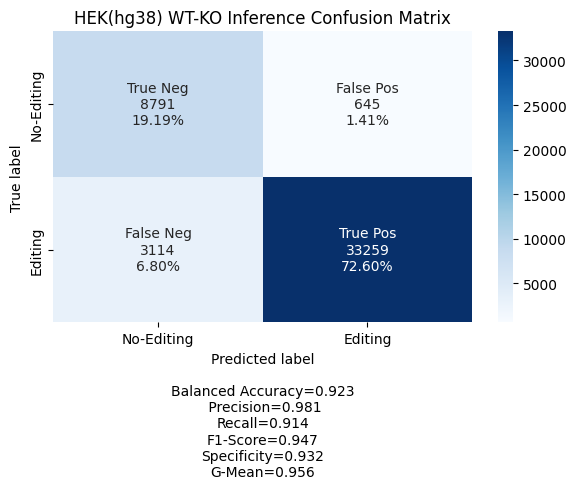

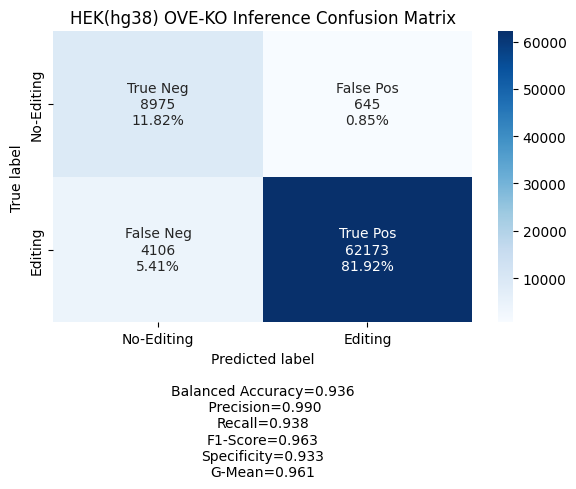

In [8]:
cells = "HEK293T"

tables, filespath =  give_inputs(cells)
make_predictions(tables, filespath, model_filepath)
bona_fide_metrics_calculator(tables, filespath, cells)

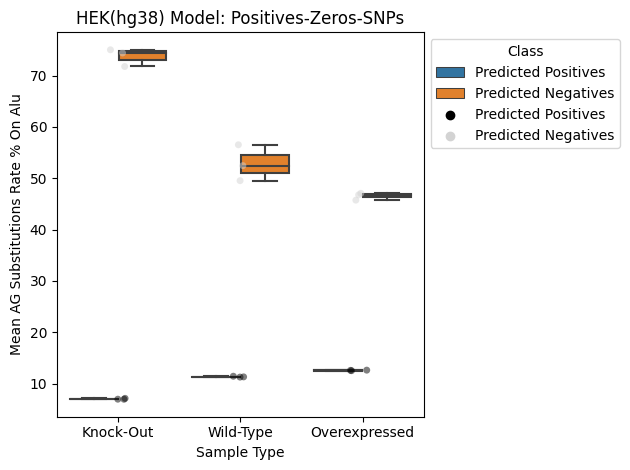

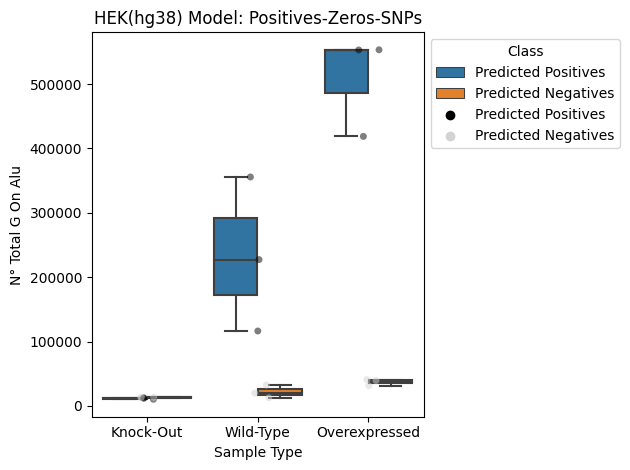

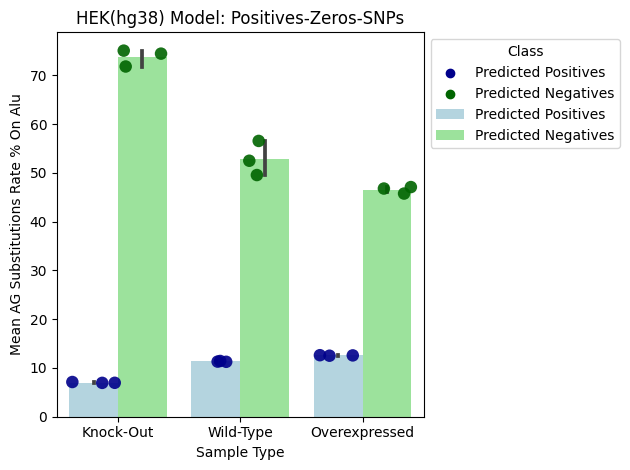

In [11]:
cells = "HEK293T"

tables, filespath =  give_inputs(cells)

def returng(x):
    return eval(x)[2]

annotation = []

for file_name in os.listdir(filespath):
    if file_name.find("bona_fide_sites.tsv") != -1 and file_name.find("candidates") == -1:
        annotation.append(pd.read_csv(os.path.join(filespath, file_name), usecols=["Region", "Position", "RMSK-Reg", "Class"], sep="\t"))
annotation = pd.concat(annotation, axis=0)
annotation = annotation[annotation.loc[:, "RMSK-Reg"].str.find("Alu")!=-1]
annotation.drop("RMSK-Reg", axis=1, inplace=True)
annotation.drop_duplicates(inplace=True)

stats = []
for i in range(3):
    for j in range(3):
        name = "{}_predictions.tsv".format(tables[i][j])
        data = pd.read_table(os.path.join(filespath, name))
        data = data.merge(annotation, how="inner", on=["Region", "Position"])
        data["G"] = data.loc[:, "BasesCounts"].apply(returng)
        data.Class = data.Class.astype("int32")
        pos = data[data.loc[:, "Class"] == 1]
        neg = data[data.loc[:, "Class"] == 0]
        freq = [100*(sum(pos["FreqAGrna"].tolist())/len(pos)), 100*(sum(neg["FreqAGrna"].tolist())/len(neg))]
        g = [sum(pos["G"].tolist()), sum(neg["G"].tolist())]
        df = pd.DataFrame(data = [freq, g]).T
        df.columns = ["Mean AG Substitutions Rate % On Alu", "N° Total G On Alu"]
        df.loc[:, "Class"] = ["Predicted Positives", "Predicted Negatives"]
        if j == 1:
            df.loc[:, "Sample Type"] = "Knock-Out"
        elif j == 0:
            df.loc[:, "Sample Type"] = "Wild-Type"
        else:
            df.loc[:, "Sample Type"] = "Overexpressed"
        df.loc[:, "Model"] = "POSITIVEs+ZEROs+SNPs"
        stats.append(df)
stats = pd.concat(stats, axis=0)
stats.reset_index(drop=True, inplace=True)
stats = stats.iloc[[2,3,8,9,14,15,0,1,6,7,12,13,4,5,10,11,16,17], :]
stats.to_csv(os.path.join(filespath, f"{cells}_boxplot_data.tsv"), sep="\t", index=None)

fig, ax = plt.subplots()

my_palette = {"Predicted Positives": "black", "Predicted Negatives": "lightgrey"}
ax = sn.boxplot(data = stats, x = "Sample Type",  y = "Mean AG Substitutions Rate % On Alu", hue="Class").set(title='HEK(hg38) Model: Positives-Zeros-SNPs')
ax = sn.stripplot(data = stats, x = "Sample Type",  y = "Mean AG Substitutions Rate % On Alu", hue="Class", alpha=0.5, palette=my_palette)
sn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

plt.savefig(f"{filespath}/{cells}_AG_Substitutions_Rate_On_Alu.tiff", dpi=300, 
            bbox_inches='tight', facecolor='white', transparent=False) 

fig, ax = plt.subplots()

my_palette = {"Predicted Positives": "black", "Predicted Negatives": "lightgrey"}
ax = sn.boxplot(data = stats, x = "Sample Type",  y = "N° Total G On Alu", hue="Class").set(title='HEK(hg38) Model: Positives-Zeros-SNPs')
ax = sn.stripplot(data = stats, x = "Sample Type",  y = "N° Total G On Alu", hue="Class", alpha=0.5, palette=my_palette)
sn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

plt.savefig(f"{filespath}/{cells}_Number_Total_G_On_Alu.tiff", dpi=300, 
            bbox_inches='tight', facecolor='white', transparent=False) 


fig, ax = plt.subplots()
palette1 = {"Predicted Positives": "lightblue", "Predicted Negatives": "lightgreen"}
sn.barplot(data=stats, x="Sample Type", y="Mean AG Substitutions Rate % On Alu", hue="Class", 
           fill=True, palette=palette1).set(title='HEK(hg38) Model: Positives-Zeros-SNPs')

palette2 = {"Predicted Positives": "darkblue", "Predicted Negatives": "darkgreen"}
sn.stripplot(data=stats, x="Sample Type", y="Mean AG Substitutions Rate % On Alu", hue="Class",
             dodge=True, size=9, alpha=0.9, jitter=0.40, palette=palette2)
sn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

plt.savefig(f"{filespath}/{cells}_AG_Substitutions_Rate_On_Alu_Barplot.tiff", dpi=300, 
            bbox_inches='tight', facecolor='white', transparent=False) 
plt.show()



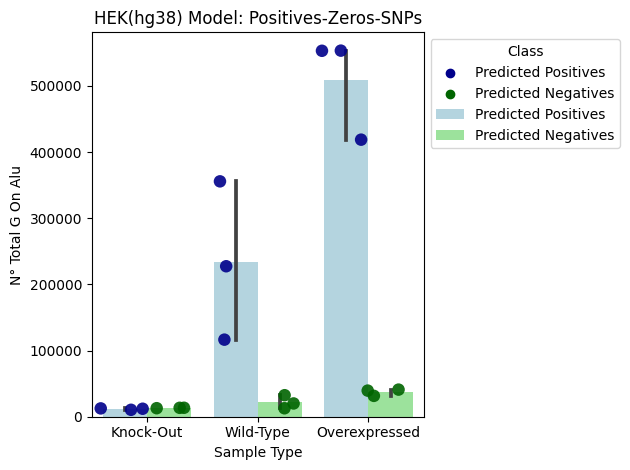

In [12]:
fig, ax = plt.subplots()
palette1 = {"Predicted Positives": "lightblue", "Predicted Negatives": "lightgreen"}
sn.barplot(data=stats, x="Sample Type", y="N° Total G On Alu", hue="Class", 
           fill=True, palette=palette1).set(title='HEK(hg38) Model: Positives-Zeros-SNPs')

palette2 = {"Predicted Positives": "darkblue", "Predicted Negatives": "darkgreen"}
sn.stripplot(data=stats, x="Sample Type", y="N° Total G On Alu", hue="Class",
             dodge=True, size=9, alpha=0.9, jitter=0.45, palette=palette2)
sn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

plt.savefig(f"{filespath}/{cells}_Number_Total_G_On_Alu_Barplot.tiff", dpi=300, 
            bbox_inches='tight', facecolor='white', transparent=False) 
plt.show()

100%|██████████| 6/6 [00:09<00:00,  1.58s/it]


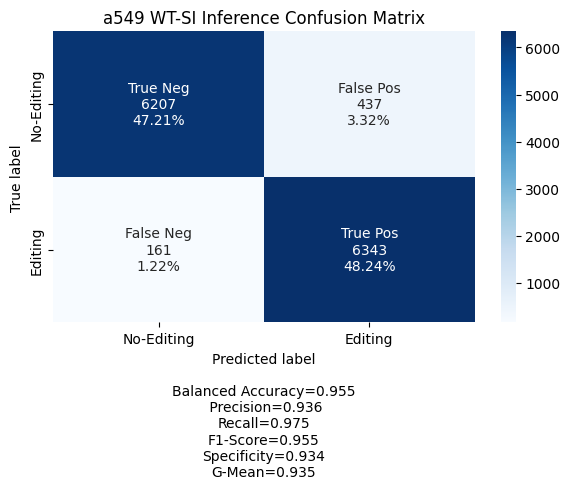

In [9]:
cells = "a549"

tables, filespath =  give_inputs(cells)
make_predictions(tables, filespath, model_filepath)
bona_fide_metrics_calculator(tables, filespath, cells)